# About
vertex based tagging: vertices are constructed in another way, like in jet-tagging LCHb approach

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import sys
sys.path.insert(0, "../")

## Import

In [2]:
import pandas
import numpy

from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

In [3]:
from utils import get_N_B_events, get_events_number, get_events_statistics

## Reading initial data

In [4]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('../datasets/MC/csv/Bu_JPsiK/Vertices_Mike.root'))

In [5]:
data.head()

,run,event,No,mult,nnkrec,Bmass,ptB,vflag,ptmean,ipsmean,...,W_M_BDphiDir,M_svtau,W_M_svtau,M_pointtheta,W_M_pointtheta,docamax,signB,signVtx,N_sig_sw,BOosc
0,2517778,1110824,0,1,4,5.27489,11.70600,2,1.564780,8.62936,...,-1.675360,1.024920,166.444000,0.067733,0.012434,0.000000,1,1,0,0
1,2517778,1110839,0,1,3,5.28328,3.88046,4,0.579329,7.54620,...,-2.229240,1.807200,15.986400,0.011598,0.098215,0.016291,-1,1,0,1
2,2517778,1110869,0,1,1,5.27815,2.78838,2,1.764510,5.58850,...,0.507730,0.484238,128503.000000,0.190129,0.017458,0.000000,1,-1,0,0
3,2517778,1110880,0,1,2,5.28571,8.92569,6,0.881253,6.91230,...,1.651890,2.628070,227.988007,0.029884,0.003415,0.085911,1,1,0,0
4,2517778,1110894,0,1,3,5.27156,10.75980,4,0.926523,12.08480,...,0.565922,2.379660,57.450001,0.035372,0.010057,0.014691,-1,1,0,0


In [6]:
len(data)

737093

In [7]:
event_id_column = 'event_id'
event_id = data.run.apply(str) + '_' + data.event.apply(str)
data['group_column'] = numpy.unique(event_id, return_inverse=True)[1]

# all weights are 1, because this is MC
data['N_sig_sw'] = 1
data[event_id_column] = event_id

In [8]:
get_events_statistics(data)

{'Events': 733032, 'parts': 737093}

In [9]:
import json
with open('../models/JPsiKMC.json', 'r') as f:
    N_B_events = json.load(f)['N_B_events']

In [10]:
N_B_events

1488891.0

In [11]:
N_pass = get_events_number(data)
tagging_efficiency = 1. * N_pass / N_B_events
tagging_efficiency_delta = sqrt(N_pass) / N_B_events
print tagging_efficiency, tagging_efficiency_delta

0.492334227287 0.000575040671035


### Define features

In [12]:
data.columns

Index([u'run', u'event', u'No', u'mult', u'nnkrec', u'Bmass', u'ptB', u'vflag',
       u'ptmean', u'ipsmean', u'vcharge', u'svm', u'svp', u'M_BDphiDir',
       u'W_M_BDphiDir', u'M_svtau', u'W_M_svtau', u'M_pointtheta',
       u'W_M_pointtheta', u'docamax', u'signB', u'signVtx', u'N_sig_sw',
       u'BOosc', u'group_column', u'event_id'],
      dtype='object')

In [13]:
features =  ['mult', u'nnkrec', u'ptB', u'vflag',
               u'ptmean', u'ipsmean', u'vcharge', u'svm', u'svp', u'M_BDphiDir',
               u'W_M_BDphiDir', u'M_svtau', u'W_M_svtau', u'M_pointtheta',
               u'W_M_pointtheta', u'docamax',]

## Vertices sum of charges asymmetry

In [14]:
from utils import compute_sum_of_charges

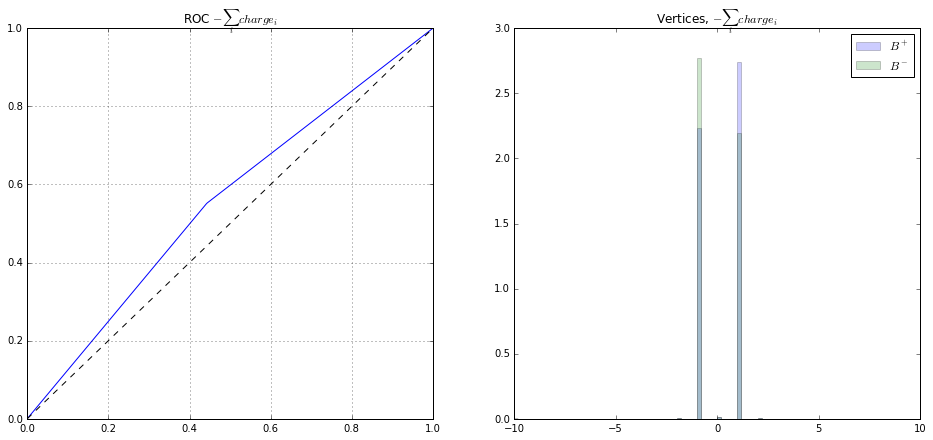

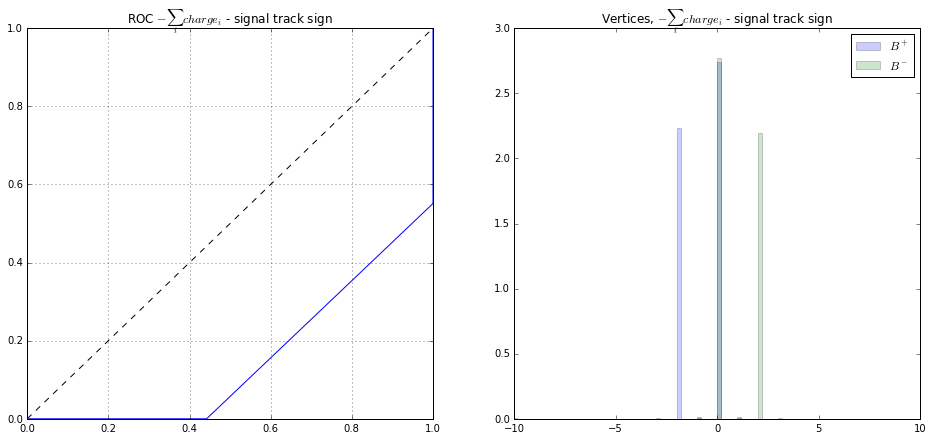

,$B^+$,"$B^+$, with signal part",$B^-$,"$B^-$, with signal part",ROC AUC,"ROC AUC, with signal part",name
0,0.102729,-0.897271,-0.115973,0.884027,0.554682,0.846214,Vertices


In [15]:
compute_sum_of_charges(data, 'Vertices', bins=100, 
                       event_id_column=event_id_column, sign_part_column='signVtx')

## Define label

In [16]:
data.loc[:, 'label'] = (data.signB.values * data.signVtx.values > 0) * 1

## DT

In [17]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from folding_group import FoldingGroupClassifier

In [18]:
data_sw_passed_lds = LabeledDataStorage(data, data.label.values)

In [19]:
tt_base = DecisionTrainClassifier(learning_rate=0.01, n_estimators=10000, depth=6,
                                  max_features=12, n_threads=12)
tt_folding = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                    train_features=features, group_feature='group_column')
%time tt_folding.fit_lds(data_sw_passed_lds)
pass

CPU times: user 10min 25s, sys: 1.59 s, total: 10min 27s
Wall time: 1min 5s


In [20]:
report = ClassificationReport({'dt': tt_folding}, data_sw_passed_lds)

KFold prediction using folds column


KFold prediction using folds column


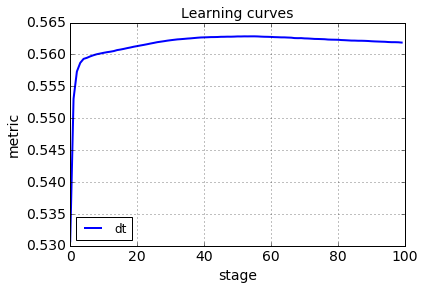

In [21]:
report.learning_curve(RocAuc(), steps=1)

In [22]:
report.compute_metric(RocAuc())

OrderedDict([('dt', 0.56186900142958185)])

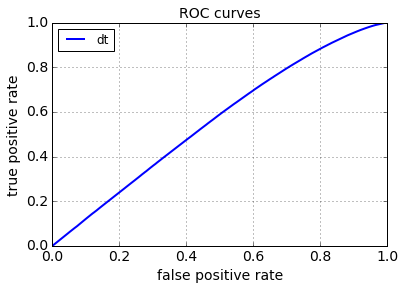

In [23]:
report.roc()

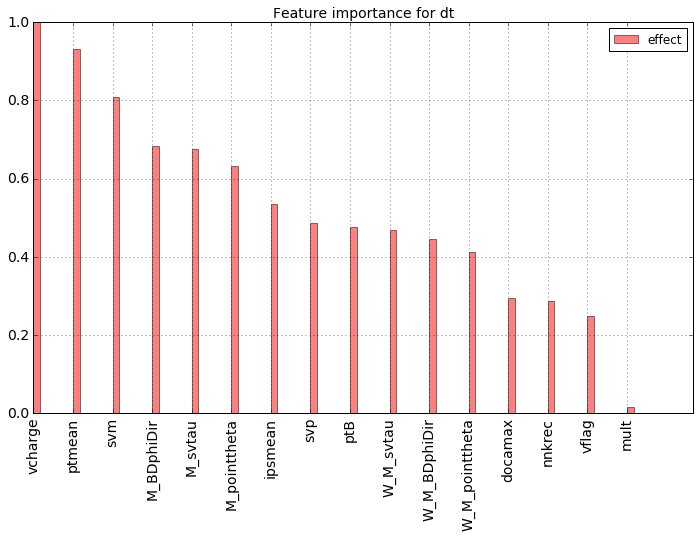

In [24]:
report.feature_importance()

In [25]:
tt_folding.estimators[0].clf.estimators = tt_folding.estimators[0].clf.estimators[:5000]
tt_folding.estimators[1].clf.estimators = tt_folding.estimators[1].clf.estimators[:5000]

--------

## Calibrating results $p(\text{vrt same sign}|B)$ and combining them

In [26]:
models = []

In [27]:
from utils import get_result_with_bootstrap_for_given_part

KFold prediction using folds column


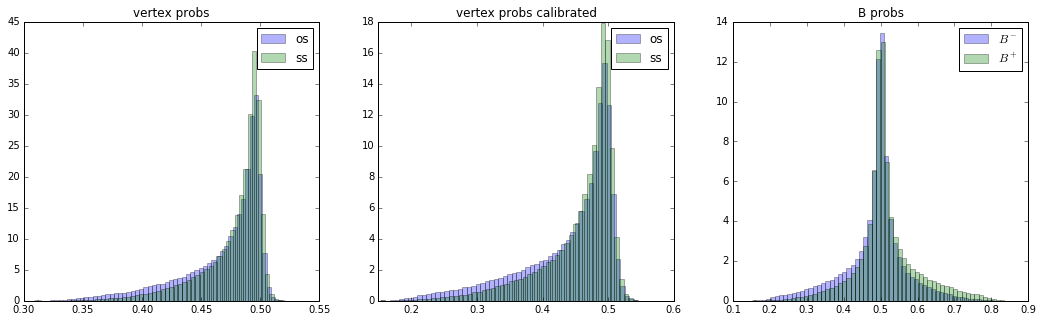

AUC for tagged: 0.584777819153 AUC with untag: 0.546740835261


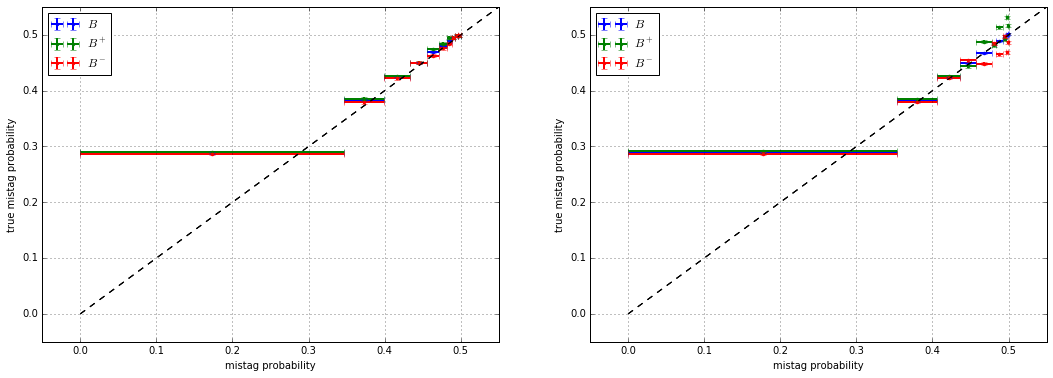

mean AUC after calibration: 0.584610185848 6.09862198963e-09


In [ ]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                      [data], N_B_events=N_B_events,
                                                      logistic=True, name="inclusive vertex", n_calibrations=30,
                                                      sign_part_column='signVtx', part_name='vertex', 
                                                      logistic_combined=False))

KFold prediction using folds column


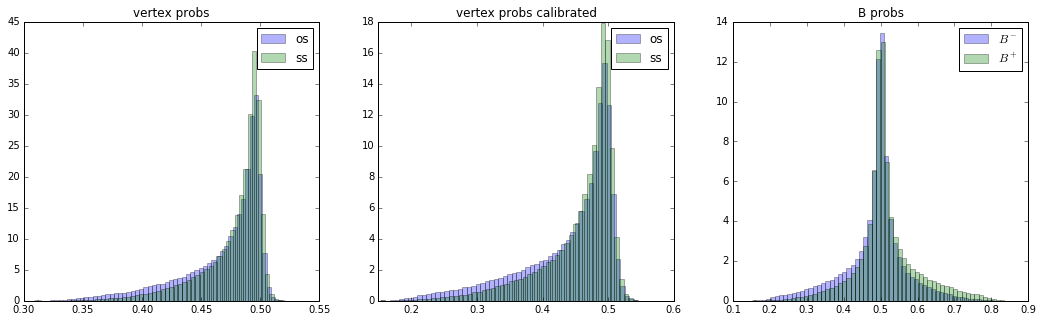

AUC for tagged: 0.584777819153 AUC with untag: 0.546740835261


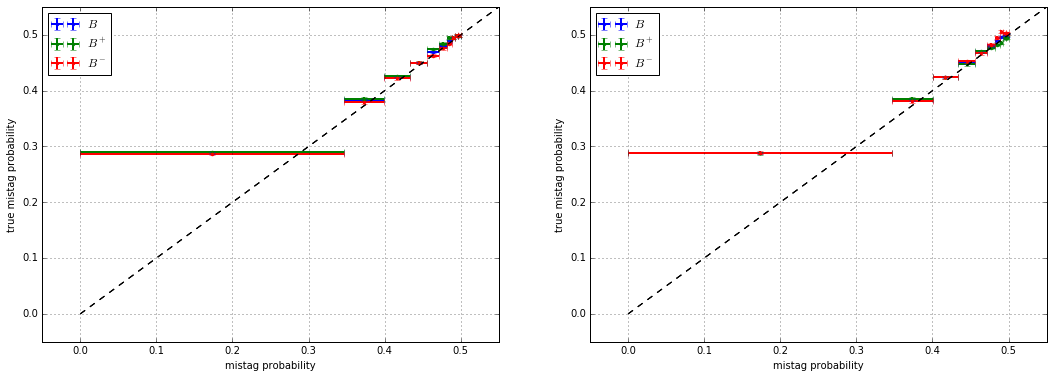

mean AUC after calibration: 0.584775556537 5.97870693052e-11


In [33]:
models.append(get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                       [data], N_B_events=N_B_events,
                                                       logistic=True, name="inclusive vertex, logistic", 
                                                       n_calibrations=30,
                                                       sign_part_column='signVtx', part_name='vertex', 
                                                       logistic_combined=True))

# Comparison of different models

In [34]:
pandas.concat(models)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,inclusive vertex,49.233423,0.057504,0.028953,0.000015,1.425464,0.001824,54.674084,0
0,"inclusive vertex, logistic",49.233423,0.057504,0.028691,0.000025,1.412537,0.002052,54.674084,0


# Prepare for combination with vertices

In [35]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column


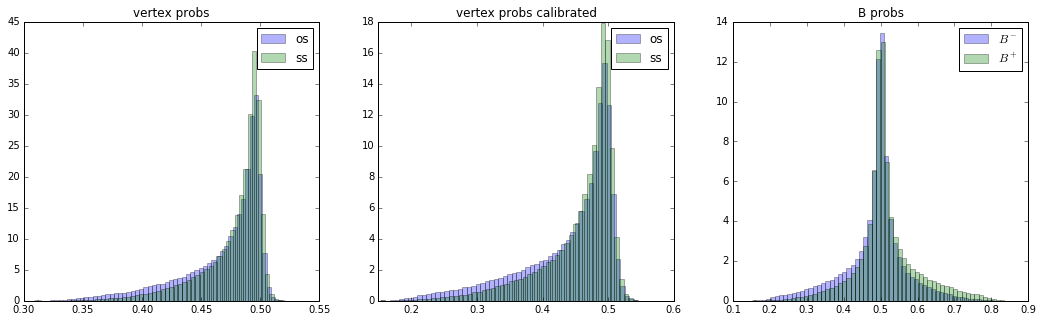

AUC for tagged: 0.584777819153 AUC with untag: 0.546740835261


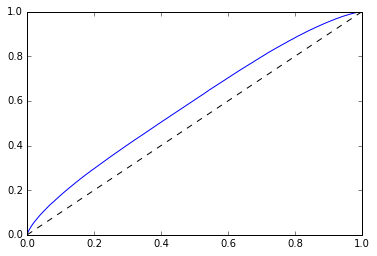

In [36]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data], logistic=True, sign_part_column='signVtx',
                                               N_B_events=N_B_events, part_name='vertex')

In [37]:
Bdata_prepared.to_csv('../models/Bdata_vertices_MC_jets.csv', header=True, index=False)